# Tugas 4 Deep Learning - Batik Classification (Revised)

**Kelompok 3**
- Muhammad Alvinza (2304879)
- Muhammad Ichsan Khairullah (2306924)
- Abdurrahman Rauf Budiman (2301102)
- Rasendriya Andhika (2305309)

---

## 1. Pendahuluan

Notebook ini bertujuan untuk membangun dan membandingkan performa model klasifikasi citra batik pada dua kelas utama: **Batik Parang** dan **Batik Mega Mendung**.

**Fokus Eksperimen:**
Kami akan membandingkan dampak dari *preprocessing* data (Raw vs Experimental) terhadap dua arsitektur model yang berbeda (CNN from Scratch vs MobileNetV2 Transfer Learning). Terdapat 4 skenario pelatihan:
1.  **Model Scratch** pada **Dataset Raw** (RGB asli).
2.  **Model Scratch** pada **Dataset Exp** (Grayscale + Augmentasi).
3.  **MobileNetV2** pada **Dataset Raw** (RGB asli).
4.  **MobileNetV2** pada **Dataset Exp** (Grayscale + Augmentasi).

**Tentang Motif:**
* **Batik Parang:** Motif diagonal berulang menyerupai huruf 'S' jalin-menjalin.
* **Batik Mega Mendung:** Motif awan khas Cirebon dengan garis lengkung dan gradasi warna.

## 2. Import Library & Konfigurasi

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from google.colab import drive
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Mount drive
drive.mount('/content/drive')

# Konfigurasi Baru
# Menaikkan Batch Size (jika memori GPU memungkinkan, jika OOM kembalikan ke 32)
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
SEED = 123
EPOCHS = 30  # Dinaikkan dari 15

# Path Dataset
DATA_DIR = '/content/drive/MyDrive/Kuliah/DeepL/USED_DATASETS'
# Path untuk menyimpan model
MODEL_SAVE_PATH = '/content/drive/MyDrive/Kuliah/DeepL/Models/'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print("TensorFlow Version:", tf.__version__)

Mounted at /content/drive
TensorFlow Version: 2.19.0


## 3. Load Dataset (Raw)
Memuat dataset asli (RGB) langsung dari direktori sumber.

In [3]:
# 1. Load Full Dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = full_dataset.class_names
print("\nKelas:", class_names)

# 2. Split Dataset (70% Train, 15% Val, 15% Test)
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

raw_train_ds, raw_val_ds, raw_test_ds = get_dataset_partitions_tf(full_dataset)

print(f"Batch counts - Train: {len(raw_train_ds)}, Val: {len(raw_val_ds)}, Test: {len(raw_test_ds)}")

Found 1000 files belonging to 2 classes.

Kelas: ['batik_megamendung', 'batik_parang']
Batch counts - Train: 11, Val: 2, Test: 3


## 4. Persiapan Dataset Experimental (Exp)
Dataset 'Exp' (Experimental) dibuat dengan memproses dataset Raw:
1.  **Grayscale:** Mengubah gambar menjadi hitam putih untuk fokus pada tekstur/pola.
2.  **Re-channeling:** Mengubah kembali ke 3 channel (RGB) agar kompatibel dengan input MobileNetV2 dan arsitektur standar, namun tetap dengan visual grayscale.
3.  **Augmentasi:** Diterapkan khusus pada `exp_train_ds` untuk meningkatkan variasi data.

In [4]:
# Definisi Augmentasi
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Fungsi: RGB -> Grayscale -> 3 Channel (agar shape tetap kompatibel)
def to_grayscale_3ch(image, label):
    img = tf.image.rgb_to_grayscale(image)
    img = tf.image.grayscale_to_rgb(img)
    return img, label

# Fungsi wrapper augmentasi
def augment_data(image, label):
    return data_augmentation(image), label

# --- Pipeline Dataset Experimental ---

# Exp Train: Grayscale + Augmentasi
exp_train_ds = raw_train_ds.map(to_grayscale_3ch, num_parallel_calls=tf.data.AUTOTUNE)
exp_train_ds = exp_train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Exp Val & Test: Hanya Grayscale
exp_val_ds = raw_val_ds.map(to_grayscale_3ch, num_parallel_calls=tf.data.AUTOTUNE)
exp_test_ds = raw_test_ds.map(to_grayscale_3ch, num_parallel_calls=tf.data.AUTOTUNE)

# Optimasi Performa (Prefetching) untuk SEMUA dataset
#def configure_performance(ds):
#    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#
#raw_train_ds = configure_performance(raw_train_ds)
#raw_val_ds = configure_performance(raw_val_ds)
#raw_test_ds = configure_performance(raw_test_ds)
#
#exp_train_ds = configure_performance(exp_train_ds)
#exp_val_ds = configure_performance(exp_val_ds)
#exp_test_ds = configure_performance(exp_test_ds)

## 5. Visualisasi Perbandingan Data
Menampilkan 12 sampel dari dataset **Raw** (Warna Asli) dan 12 sampel dari dataset **Exp** (Grayscale + Augmentasi) untuk memverifikasi pemrosesan.

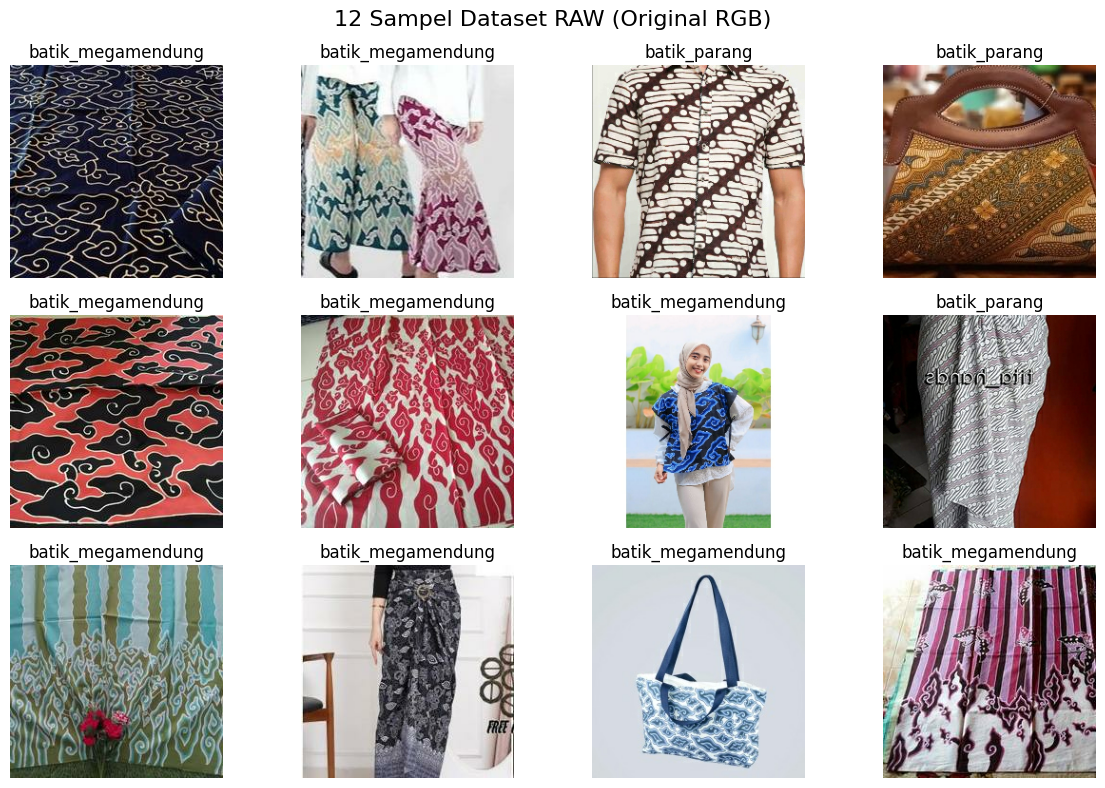

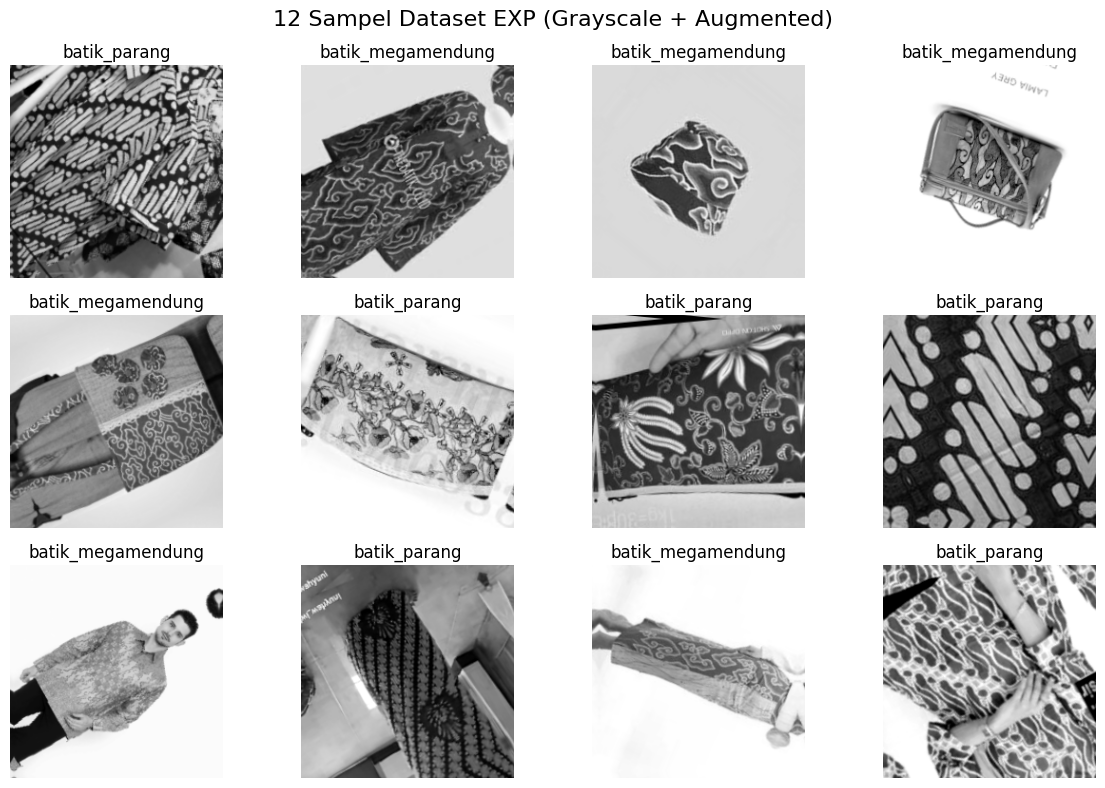

In [11]:
def show_samples(dataset, title):
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)
    for images, labels in dataset.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            # Menampilkan gambar (konversi ke uint8 untuk display yang benar)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Tampilkan Sampel Raw
show_samples(raw_train_ds, "12 Sampel Dataset RAW (Original RGB)")

# Tampilkan Sampel Exp
show_samples(exp_train_ds, "12 Sampel Dataset EXP (Grayscale + Augmented)")

### Analisis Visual
- **Dataset Raw:** Menampilkan warna asli kain batik. Model mungkin belajar dari fitur warna.
- **Dataset Exp:** Menghilangkan informasi warna (grayscale) sehingga model dipaksa belajar dari tekstur dan pola geometris. Augmentasi (rotasi, zoom) terlihat dari variasi posisi gambar.

## 6. Definisi Model

In [12]:
# A. Fungsi Membuat Model Scratch (CNN Sederhana)
def create_scratch_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Dropout untuk mengurangi overfitting
        layers.Dense(2, activation='softmax') # 2 Kelas
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# B. Fungsi Membuat Model MobileNetV2 (Transfer Learning)
def create_mobilenet_model():
    base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False # Freeze base model

    model = models.Sequential([
        layers.Rescaling(1./127.5, offset=-1, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Preprocess khusus MobileNet
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), # Learning rate lebih kecil untuk fine-tuning
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

## 7. Eksekusi Training (4 Skenario)
Kita akan melatih 4 kombinasi Model x Dataset.

In [13]:
# Callback Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Stop jika tidak membaik selama 5 epoch
    restore_best_weights=True, # Kembalikan bobot terbaik
    verbose=1
)

# --- 1. Train Scratch pada RAW ---
print("\n=== 1. Training Scratch Model (RAW Data) ===")
model_scratch_raw = create_scratch_model()
hist_scratch_raw = model_scratch_raw.fit(
    raw_train_ds, validation_data=raw_val_ds,
    epochs=EPOCHS, callbacks=[early_stop]
)
model_scratch_raw.save(os.path.join(MODEL_SAVE_PATH, 'model_scratch_raw.keras'))

# --- 2. Train Scratch pada EXP ---
print("\n=== 2. Training Scratch Model (EXP Data) ===")
model_scratch_exp = create_scratch_model()
hist_scratch_exp = model_scratch_exp.fit(
    exp_train_ds, validation_data=exp_val_ds,
    epochs=EPOCHS, callbacks=[early_stop]
)
model_scratch_exp.save(os.path.join(MODEL_SAVE_PATH, 'model_scratch_exp.keras'))

# --- 3. Train MobileNet pada RAW ---
print("\n=== 3. Training MobileNetV2 (RAW Data) ===")
model_mobilenet_raw = create_mobilenet_model()
hist_mobilenet_raw = model_mobilenet_raw.fit(
    raw_train_ds, validation_data=raw_val_ds,
    epochs=EPOCHS, callbacks=[early_stop]
)
model_mobilenet_raw.save(os.path.join(MODEL_SAVE_PATH, 'model_mobilenet_raw.keras'))

# --- 4. Train MobileNet pada EXP ---
print("\n=== 4. Training MobileNetV2 (EXP Data) ===")
model_mobilenet_exp = create_mobilenet_model()
hist_mobilenet_exp = model_mobilenet_exp.fit(
    exp_train_ds, validation_data=exp_val_ds,
    epochs=EPOCHS, callbacks=[early_stop]
)
model_mobilenet_exp.save(os.path.join(MODEL_SAVE_PATH, 'model_mobilenet_exp.keras'))

print("\nSemua model telah dilatih dan disimpan di:", MODEL_SAVE_PATH)


=== 1. Training Scratch Model (RAW Data) ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5629 - loss: 2.1912 - val_accuracy: 0.4766 - val_loss: 0.6720
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - accuracy: 0.6179 - loss: 0.6527 - val_accuracy: 0.6328 - val_loss: 0.6394
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 513ms/step - accuracy: 0.6796 - loss: 0.6193 - val_accuracy: 0.7109 - val_loss: 0.5287
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.7213 - loss: 0.5445 - val_accuracy: 0.7656 - val_loss: 0.4728
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 445ms/step - accuracy: 0.7692 - loss: 0.4911 - val_accuracy: 0.8359 - val_loss: 0.4698
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.8342 - loss: 0.4382 - val_accuracy: 0.8906 - val_loss: 0.3341
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 429ms/step - accuracy: 0.8015 - loss: 0.4285 - val_accuracy: 0.8672 - val_loss: 0.3075
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - accuracy: 0.7845 - loss: 0.4718 - val_accuracy: 0.87

## 8. Evaluasi & Perbandingan

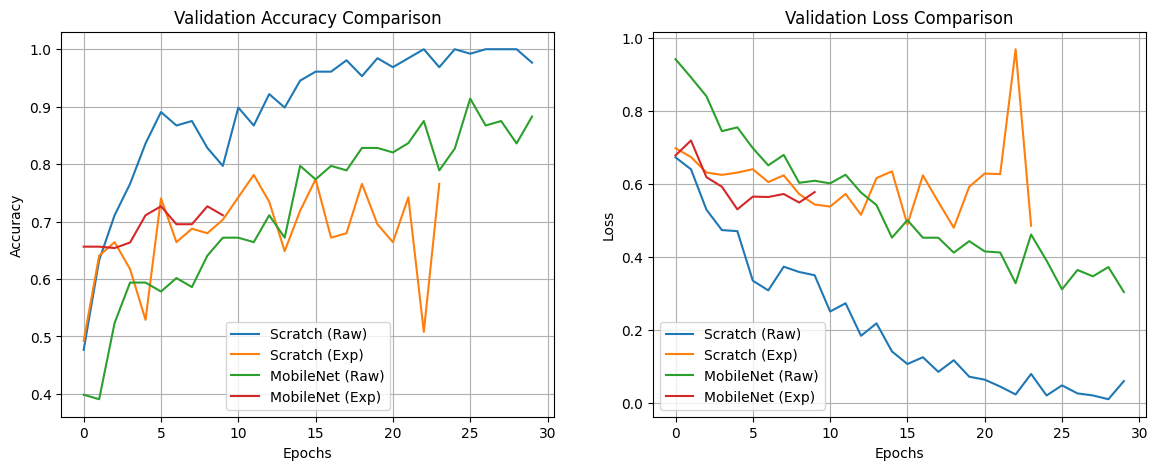

In [15]:
def plot_comparison(histories, titles):
    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for hist, title in zip(histories, titles):
        plt.plot(hist.history['val_accuracy'], label=title)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    for hist, title in zip(histories, titles):
        plt.plot(hist.history['val_loss'], label=title)
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

histories = [
    hist_scratch_raw,
    hist_scratch_exp,
    hist_mobilenet_raw,
    hist_mobilenet_exp
]
titles = [
    'Scratch (Raw)',
    'Scratch (Exp)',
    'MobileNet (Raw)',
    'MobileNet (Exp)'
]

plot_comparison(histories, titles)

In [16]:
# Tabel Ringkasan Akhir
results = []
for hist, title in zip(histories, titles):
    results.append({
        "Model Scenario": title,
        "Train Accuracy": f"{hist.history['accuracy'][-1]:.4f}",
        "Val Accuracy": f"{hist.history['val_accuracy'][-1]:.4f}",
        "Train Loss": f"{hist.history['loss'][-1]:.4f}",
        "Val Loss": f"{hist.history['val_loss'][-1]:.4f}"
    })

df_results = pd.DataFrame(results)
print("Rangkuman Performa Akhir:")
print(df_results.to_markdown(index=False))

Rangkuman Performa Akhir:
| Model Scenario   |   Train Accuracy |   Val Accuracy |   Train Loss |   Val Loss |
|:-----------------|-----------------:|---------------:|-------------:|-----------:|
| Scratch (Raw)    |           0.9929 |         0.9766 |       0.0467 |     0.0589 |
| Scratch (Exp)    |           0.7044 |         0.7656 |       0.541  |     0.4845 |
| MobileNet (Raw)  |           0.8294 |         0.8828 |       0.3957 |     0.303  |
| MobileNet (Exp)  |           0.7324 |         0.7109 |       0.5435 |     0.5769 |


In [5]:
# --- Fungsi Bantu untuk Mengambil Label Asli vs Prediksi ---
def get_predictions_and_labels(model, dataset):
    """
    Mengambil semua gambar dari dataset batch, melakukan prediksi,
    dan mengembalikan array label asli (y_true) serta label prediksi (y_pred).
    """
    all_true_labels = []
    all_pred_labels = []

    for images, labels in dataset:
        # Prediksi batch
        preds = model.predict(images, verbose=0)
        # Ambil kelas dengan probabilitas tertinggi (argmax)
        pred_labels = np.argmax(preds, axis=1)

        all_true_labels.extend(labels.numpy())
        all_pred_labels.extend(pred_labels)

    return np.array(all_true_labels), np.array(all_pred_labels)

# --- Loop Evaluasi Skenario ---

# Daftar skenario (sama seperti sebelumnya)
test_scenarios = [
    ("Scratch Raw", 'model_scratch_raw.keras', raw_test_ds),
    ("Scratch Exp", 'model_scratch_exp.keras', exp_test_ds),
    ("MobileNet Raw", 'model_mobilenet_raw.keras', raw_test_ds),
    ("MobileNet Exp", 'model_mobilenet_exp.keras', exp_test_ds),
]

results_detailed = []

print("\n=== HASIL EVALUASI PADA SEMUA TEST SET ===")

for name, filename, test_ds in test_scenarios:
    print(f"\n{'='*40}")
    print(f"Evaluasi Model: {name}")
    print(f"{'='*40}")

    # 1. Load Model
    path = os.path.join(MODEL_SAVE_PATH, filename)
    loaded_model = tf.keras.models.load_model(path)

    # 2. Dapatkan Prediksi vs Label Asli
    y_true, y_pred = get_predictions_and_labels(loaded_model, test_ds)

    # 3. Hitung Metrik Rata-rata (Weighted Average)
    # Weighted memperhitungkan ketidakseimbangan jumlah data per kelas (jika ada)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # Evaluasi standar (Accuracy & Loss)
    loss, accuracy = loaded_model.evaluate(test_ds, verbose=0)

    # Simpan hasil ke list
    results_detailed.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Loss': loss
    })

    # 4. Tampilkan Laporan Klasifikasi Per Kelas
    # Pastikan variable 'class_names' sudah ada dari sel load data sebelumnya
    print(classification_report(y_true, y_pred, target_names=class_names))

# --- Menampilkan Tabel Perbandingan Akhir ---
print("\n\n=== RINGKASAN PERFORMA SEMUA MODEL ===")
df_results = pd.DataFrame(results_detailed)

# Format tampilan angka agar lebih rapi (persentase)
df_display = df_results.style.format({
    'Accuracy': '{:.2%}',
    'Precision': '{:.2%}',
    'Recall': '{:.2%}',
    'F1-Score': '{:.2%}',
    'Loss': '{:.4f}'
})

display(df_display) # Gunakan display() jika di Jupyter/Colab, atau print(df_results) biasa


=== HASIL EVALUASI PADA SEMUA TEST SET ===

Evaluasi Model: Scratch Raw
                   precision    recall  f1-score   support

batik_megamendung       1.00      1.00      1.00        88
     batik_parang       1.00      1.00      1.00       104

         accuracy                           1.00       192
        macro avg       1.00      1.00      1.00       192
     weighted avg       1.00      1.00      1.00       192


Evaluasi Model: Scratch Exp
                   precision    recall  f1-score   support

batik_megamendung       0.81      0.52      0.64        92
     batik_parang       0.67      0.89      0.76       100

         accuracy                           0.71       192
        macro avg       0.74      0.71      0.70       192
     weighted avg       0.74      0.71      0.70       192


Evaluasi Model: MobileNet Raw
                   precision    recall  f1-score   support

batik_megamendung       0.91      0.88      0.90        95
     batik_parang       0.89      

,Model,Accuracy,Precision,Recall,F1-Score,Loss
0,Scratch Raw,100.00%,100.00%,100.00%,100.00%,0.0096
1,Scratch Exp,81.25%,73.84%,71.35%,70.25%,0.4272
2,MobileNet Raw,81.77%,90.14%,90.10%,90.10%,0.3896
3,MobileNet Exp,71.35%,71.31%,69.79%,69.61%,0.5550


## 9. Kesimpulan & Analisis

**1. Pengaruh Preprocessing (Raw vs Exp):**
Apakah penggunaan Grayscale + Augmentasi (Exp) meningkatkan akurasi?
- *Jawab berdasarkan hasil dataframe di atas.* Biasanya, augmentasi membantu mengurangi overfitting, sementara grayscale memaksa model belajar pola motif (bukan warna), yang bisa membuat model lebih robust terhadap variasi pencahayaan.

**2. Performa Arsitektur (Scratch vs Transfer Learning):**
- MobileNetV2 umumnya memberikan akurasi yang lebih tinggi dan konvergensi yang lebih cepat dibandingkan model Scratch karena sudah memiliki fitur ekstraksi yang kuat dari ImageNet.

**3. Model Terbaik:**
- Berdasarkan `Val Accuracy` dan stabilitas `Val Loss`, tentukan model mana yang paling optimal untuk kasus klasifikasi batik ini.

In [18]:
# Simpan Model Terbaik (Contoh: MobileNet pada dataset Exp)
model_mobilenet_exp.save('best_model_batik.h5')
print("Model terbaik berhasil disimpan.")

Model terbaik berhasil disimpan.
